# Optimización de parámetros para el problema del viajante (TSP) utilizando un algoritmo de colonia de hormigas (AC)

## Librerias importadas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import operator
import pandas as pd
import sys
from sklearn.neighbors import NearestNeighbors
import time

## Lectura del archivo TSP

In [2]:
# Get the data from the TSP file
def getTsp(tsp):
    # Open input file
    infile = open(tsp, 'r')

    # Read lines and keep info
    # Name
    name = infile.readline().strip().split()[1]  
    # Comment
    comment = infile.readline().strip().split()[1]
    # Type
    ty = infile.readline().strip().split()[1]
    # Dimension
    dimension = infile.readline().strip().split()[1]
    # Edge weight type
    edge_weight_type = infile.readline().strip().split()[1]
    
    # List of the coordenates of the nodes
    nodes = []                                                      
    infile.readline()
    # Read node coord section and store its coordinates
    for i in range(0, int(dimension)):
        x, y = infile.readline().strip().split()[1:]
        nodes.append([float(x), float(y)])

    # Close input file
    infile.close()

    # Return the file's data as dictionary
    return {
        'name': name,
        'type': ty,
        'comment': comment,
        'dimension': dimension,
        'edge_weight_type': edge_weight_type,
        'node_coord_section': nodes
    }

## Ant Collony Optimization (ACO)

### Funciones auxiliares

In [3]:
# Calculates the distance between every node from the space given
def calc_dist(nodes, num_nodes):
    
    # Initialize distance matrix
    distance_matrix = np.zeros((num_nodes, num_nodes))
    
    # Get points coordinates
    x = nodes[:,0]
    y = nodes[:,1]
    
    # Calculate the euclidean distance between every point
    for i in range(num_nodes):
        for j in range(num_nodes):
            distance_matrix[i][j] = math.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
    
    # Return the distance matrix
    return distance_matrix

# Initialize the pheromones matrix as seen in class
# The initial pheromone trial is a matrix of values calculated as m/C, being:
# * m = number of ants (colony)
# * C = the length of the tour generated by the nearest neighbor heuristic.
# Returns the pheromone trail
def new_pheromones(nodes, num_nodes, colony):
    # Initialize with a matrix of zeros the pheromone trail
    pheromones = np.zeros((num_nodes, num_nodes))
    
    # Calculate the tour generated by the nearest neighbor heuristic
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(nodes)
    distances, indices = nbrs.kneighbors(nodes)
    # Calculate the initial pheromones (m/C)
    tau_0 = colony/len(distances)
    for i in range(0, num_nodes):
        pheromones[i,:] = tau_0
    
    #Retrun the complete path with the initial pheromones  
    return pheromones

# Calculate the eta parameter
# It is a matrix of inverse distances
def calc_eta(distances, num_nodes):
    # Initialize eta
    eta = np.zeros((num_nodes, num_nodes))
    
    # Fill the matrix
    for i in range(distances.shape[0]):
        for j in range(distances.shape[0]):
            # To avoid divisions by zero, I put a 0 on the value where it can come
            if distances[i,j]==0:
                eta[i, j]=0
            # For the rest, get the inverse
            else:
                eta[i,j] = 1/distances[i,j]
                
    # Return the matrix of inverted distances
    return eta

# Main function of the algorithm
# Initialize randomly the ants
# Inputs:
# * n_dim = number of nodes to visit (int)
# * table = record of the moves that ants do
# * colony = total number of ants (int)
# * alpha = alpha parameter
# * beta = beta parameter
# * tau = pheromones track
# * eta = list of the inverses of the distances
def move_ants(n_dim, colony, alpha, beta, tau, eta):
    # Initialize path table
    table = np.zeros((colony, n_dim)).astype(np.int)
    # Calculate the probability of movement
    prob_num = (tau ** alpha) * (eta** beta)
    # For each ant in the colony
    for j in range(colony):
        # Randomly initialize ants' first positions
        table[j, 0] = np.random.randint(n_dim)
        # For each of the nodes
        for k in range(n_dim-1):
            # Store the already visited nodes
            visited = set(table[j, :k + 1])
            # Set a list of nodes to visit
            to_visit = list(set(range(n_dim)) - visited)
            # Calculate the probability
            prob = prob_num[table[j, k], to_visit]
            prob = prob / sum(prob)
            # Set the next destination of the ant
            next_point = np.random.choice(to_visit, size=1, p=prob)[0]
            table[j, k + 1] = next_point
            
    return table

# Calculate delta tau
# It is calculated as Q/dist, 
# with Q being a constant define at the start of the execution
# and dist, the best distance of an iteration
# It is used to update the pheromones
def calc_del_tau(table, n_dim, colony, q, dist):
    del_tau = np.zeros((n_dim, n_dim))
    for j in range(colony):
        for k in range(n_dim - 1):
            n1, n2 = table[j, k], table[j, k + 1] 
            del_tau[n1, n2] += q / dist
        n1, n2 = table[j, n_dim - 1], table[j, 0]
        del_tau[n1, n2] += q / dist
        
    return del_tau

# Calculates the best distance
def calc_best(generation_best_coord):
    # Initialize variables
    cont = -1
    best_cont = 0
    min_distance = 0
    best_coord = None
    
    for path_coords in generation_best_coord:
        # Empty distance
        distance = 0
        
        # For each node from second to last
        for path_node in range(0, path_coords.shape[0]):
            # Calculate distance to the last node
            distance += sum(np.sqrt((path_coords[path_node] - path_coords[path_node - 1])**2))
            
        cont += 1
        # Update minimun distance and path if less nor non existent
        if not min_distance or min_distance > distance:
            min_distance = distance
            best_coord = path_coords
            best_cont = cont
            
    return min_distance, best_cont

### Algoritmo principal

In [4]:
def ACO(nodes, iterations, colony, alpha, beta, q, rho):
    
    # Initialize variables
    # Number of nodes
    n_dim = nodes.shape[0]
    # Pheromones trail
    tau = new_pheromones(nodes, n_dim, colony)
    # Initial distances
    distance_matrix = calc_dist(nodes, n_dim)
    # Eta parameter (inverse of the distances)
    prob_matrix_distance = calc_eta(distance_matrix, n_dim)
    # Arrays for the best path and its coordenates of an iterations
    generation_best_path, generation_best_coord = [], []
    # Best global path, its coordenates and distance
    best_path, best_coord, min_distance = None, None, 0
    
    # For each iteration
    for i in range(iterations):
        
        # Move ants
        table = move_ants(n_dim, colony, alpha, beta, tau, prob_matrix_distance)
        
        # Get list of the coordenates of the paths
        current_paths = np.array([nodes[i] for i in table])
        
        # Calculate best distance to get the best path
        best_current_dist, index_best = calc_best(current_paths)
        
        print("The best distance for iteration ", i, "is ", best_current_dist)
        
        # Add it to list of the best path of each iteration
        path_best = table[index_best, :].copy()
        coord_best =  current_paths[index_best].copy()
        generation_best_path.append(path_best)
        generation_best_coord.append(coord_best)
        
        # Update pheromones
        del_tau = calc_del_tau(table, n_dim, colony, q,  best_current_dist)

        tau = (1 - rho) * tau + del_tau
        
    # Calculate best of every iteration
    min_distance, best_cont = calc_best(generation_best_coord)
        
    best_path = generation_best_path[best_cont]
    best_path = np.append(best_path, best_path[0])
    
    return best_path, int(min_distance)

## Selección de archivo

El código y los archivos de datos deben estar en la misma carpeta.
En file_path, poner el nombre y la extensión del archivo tsp a leer.

In [5]:
# Get TSP data
file_path = "131.tsp"
TSP = getTsp(file_path)

# Get nodes
node_list = np.array(TSP['node_coord_section'])

## Ejecución

The best distance for iteration  0 is  806.0
The best distance for iteration  1 is  824.0
The best distance for iteration  2 is  826.0
The best distance for iteration  3 is  810.0
The best distance for iteration  4 is  850.0
The best distance for iteration  5 is  856.0
The best distance for iteration  6 is  828.0
The best distance for iteration  7 is  780.0
The best distance for iteration  8 is  848.0
The best distance for iteration  9 is  816.0
--- 64.68494415283203 seconds ---


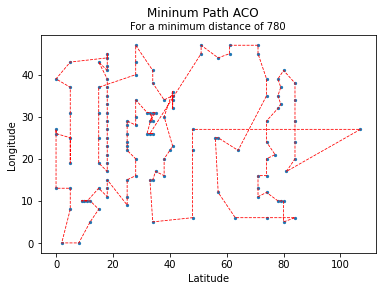

In [7]:
# Run
n_dim = node_list.shape[0]
start_time = time.time()
ACO_path, ACO_distance = ACO(node_list, iterations = 10, colony = n_dim, alpha = 1.0, beta = 6.0, q = 1.0, rho = 0.1)
print("--- %s seconds ---" % (time.time() - start_time))

# Plot path
plt.scatter(node_list[:, 0], node_list[:, 1], s=5)
plt.plot(node_list[ACO_path, 0], node_list[ACO_path, 1], c='r', linewidth=0.8, linestyle="--")

# Plot properties
plt.suptitle('Mininum Path ACO')
plt.title('For a minimum distance of {}'.format(ACO_distance), fontsize = 10)
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Show plot
plt.show()
plt.close()